cont'd from **swap_classifier(Nov10).ipynb**

In [1]:
import sys 
sys.path.append('/home/quic/QUIC-Projects/')
print(sys.path)

['/home/quic/QUIC-Projects/summary_ipynb', '/home/quic/.vscode-server/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/vscode_datascience_helpers/../.does-not-exist', '/home/quic/.vscode-server/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles', '/home/quic/.vscode-server/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/lib/python', '/home/quic/anaconda3/envs/quic/lib/python38.zip', '/home/quic/anaconda3/envs/quic/lib/python3.8', '/home/quic/anaconda3/envs/quic/lib/python3.8/lib-dynload', '', '/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages', '/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages/IPython/extensions', '/home/quic/.ipython', '/home/quic/QUIC-Projects/']


# Change 1 : New Objective funciton #
## Reduce equality constraint ##
Let $\phi(x) \rightarrow [\phi(x); 1]$, then $K(x,y) \rightarrow K(x, y)+1$ objective funciton and classifing equation is, ($ K(\dot{} , \dot{} )=|\left<{\dot{}, \dot{}}\right>|^2$)
$$\min_{0\leq \alpha \leq 1}{\frac{C}{2}\sum_{i, j}{\alpha_i\alpha_j y_i y_j K(x_i , x_j)} + \frac{C}{2}\left(\sum_{i}{\alpha_i y_i}\right)^2 - \sum_i{\alpha_i}}$$<br>
$$ \hat{y} = sgn\left[\sum_{i=1}^{2^n}{\alpha_i y_iK(x_i, x)} + \sum_i{\alpha_i y_i}\right] $$

## Use **custum_qiskit_v2**

In [4]:
import custom_qiskit_v2.classifier as cl2
import custom_qiskit.classifier as cl1
from custom_qiskit_v2.datageneration import sklearn_data
import numpy as np 

In [5]:
X, y, Xt, yt = sklearn_data('iris', 2**6, (0, 1, 2, 3), (1, 2), 'nb')
svm1 = cl1.SVM(X, y, C=10)
svm1.optimize(np.random.rand(svm1.num_data), mimic='svm')
svm1.check_performance(Xt, yt)

0.9166666666666666

In [4]:
svm2 = cl2.SVM(X, y, C=10)
svm2.optimize(np.random.rand(svm2.num_data), mimic='svm')
svm2.accuracy(Xt, yt)

0.9722222222222222

In [5]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit_v2.classifier import SVM
from custom_qiskit_v2.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm.notebook import tqdm
from custom_qiskit.datageneration import sklearn_data
from sklearn.datasets import make_circles, make_moons

def f(C):
    X, y, Xt, yt = sklearn_data('wine', 2**6, range(13), (1, 2), 'nb')
    idx = np.random.choice(2**6, 2**5, replace=False)
    svm1 = SVM(X, y, C=C)
    svm2 = SVM(X, y, C=C)
    svm3 = SVM(X, y, C=C)
    svm4 = SVM(X, y, C=C)
    svm1.optimize(np.random.rand(svm1.num_data), maxiter=1000)
    svm2.optimize(np.random.rand(svm2.num_data), maxiter=1000, mimic='qsvm')
    svm3.optimize(np.random.rand(svm3.num_data), validation_data=X, validation_label=y, maxiter=1000, mimic='qesvm')
    svm4.optimize(np.random.rand(svm4.num_data), maxiter=1000, mimic = 'qusvm')
    return [C, svm1.accuracy(Xt, yt), svm2.accuracy(Xt, yt), svm3.accuracy(Xt, yt), svm4.accuracy(Xt, yt)]

Cs = np.array([np.logspace(-4, 4, 100) for _ in range(100)]).reshape(-1)
if __name__=='__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        res = list(tqdm(pool.imap_unordered(f, tuple(Cs)), total=Cs.size))
res = sorted(res, key=lambda x:x[0])

a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:5]
err_std = a.std(axis=1)[:, 1:5]
C = a.mean(axis=1)[:,0]

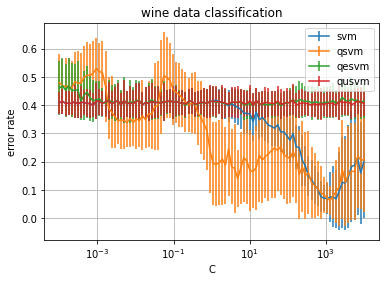

In [6]:
import matplotlib.pyplot as plt
plt.errorbar(C[:], err_mean[:, 0], yerr=err_std[:, 0], label='svm')
plt.errorbar(C[:], err_mean[:, 1], yerr=err_std[:, 1], label='qsvm')
plt.errorbar(C[:], err_mean[:, 2], yerr=err_std[:, 2], label='qesvm')
plt.errorbar(C[:], err_mean[:, 3], yerr=err_std[:, 3], label='qusvm')
plt.xscale('log')

plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('error rate')
plt.title('wine data classification')
plt.show()

In [7]:
err_trc = np.array(err_mean, copy=True)

optC1 = C[np.argmin(err_trc[:, 0])]
optC2 = C[np.argmin(err_trc[:, 1])]
optC3 = C[np.argmin(err_trc[:, 2])]
optC4 = C[np.argmin(err_trc[:, 3])]
print(optC1, optC2, optC3, optC4)

1873.8174228603887 1291.5496650148852 12.328467394420686 12.328467394420686


wine data


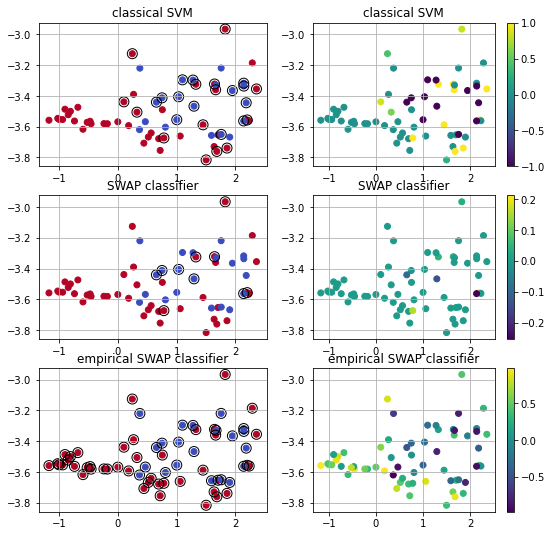

In [8]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit_v2.classifier import SVM
from custom_qiskit.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm import tqdm, tqdm_notebook
from custom_qiskit.datageneration import sklearn_data

option1 = 'sv tsne'
option2 = 'density tsne'

X, y, Xt, yt = sklearn_data('wine', 2**6, range(13), (1, 2), 'nb')
idx = np.random.choice(2**6, 2**5, replace=False)
svm1 = SVM(X, y, C=optC1)
svm2 = SVM(X, y, C=optC2)
svm3 = SVM(X, y, C=optC3)
svm4 = SVM(X, y, C=optC4)
svm1.optimize(np.random.rand(svm1.num_data), maxiter=1000)
svm2.optimize(np.random.rand(svm2.num_data), maxiter=1000, mimic='qsvm')
svm3.optimize(np.random.rand(svm3.num_data), validation_data=X, validation_label=y, maxiter=1000, mimic='qesvm')
svm4.optimize(np.random.rand(svm4.num_data), maxiter=1000, mimic = 'qusvm')
Xe = svm1.tsne(50)
svm1.data_emb = Xe
svm2.data_emb = Xe
svm3.data_emb = Xe
fig, axes = plt.subplots(3, 2, figsize=(9, 9))
svm1.plot(axes=axes[0, 0], option=option1)
svm2.plot(axes=axes[1, 0], option=option1)
svm3.plot(axes=axes[2, 0], option=option1)
svm1.plot(axes=axes[0, 1], option=option2)
svm2.plot(axes=axes[1, 1], option=option2)
svm3.plot(axes=axes[2, 1], option=option2)
axes[0, 0].set_title('classical SVM')
axes[1, 0].set_title('SWAP classifier')
axes[2, 0].set_title('empirical SWAP classifier')
axes[0, 1].set_title('classical SVM')
axes[1, 1].set_title('SWAP classifier')
axes[2, 1].set_title('empirical SWAP classifier')
print('wine data')

In [9]:
print('Empirical correct probability of')
print('\tclassical SVM:                    {:.3%}'.format(svm1.accuracy(Xt, yt)))
print('\tSWAP gate classifier:             {:.3%}'.format(svm2.accuracy(Xt, yt)))
print('\tempirical SWAP gate classifier:   {:.3%}'.format(svm3.accuracy(Xt, yt)))
print('\tUniform SWAP classifier:          {:.3%}'.format(svm4.accuracy(Xt, yt)))
print('for wine dataset')

Empirical correct probability of
	classical SVM:                    90.909%
	SWAP gate classifier:             96.364%
	empirical SWAP gate classifier:   50.909%
	Uniform SWAP classifier:          50.909%
for wine dataset


In [2]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit_v2.classifier import SVM
from custom_qiskit_v2.pseudo_swap_classifier import pseudo_empirical_SWAP_classifier, pseudo_SWAP_classifier, pseudo_uniform_SWAP_classifier
from tqdm.notebook import tqdm
from custom_qiskit.datageneration import sklearn_data
from sklearn.datasets import make_circles, make_moons

def f(C):
    X, y, Xt, yt = sklearn_data('iris', 2**6, range(4), (1, 2), 'nb')
    idx = np.random.choice(2**6, 2**5, replace=False)
    svm1 = SVM(X, y, C=C)
    svm2 = SVM(X, y, C=C)
    svm3 = SVM(X, y, C=C)
    svm1.optimize(np.random.rand(svm1.num_data), maxiter=1000)
    svm2.optimize(np.random.rand(svm2.num_data), maxiter=1000, mimic='qsvm')
    svm3.optimize(np.random.rand(svm3.num_data), maxiter=1000, mimic='qesvm', validation_data=X, validation_label=y)
    return [C, svm1.accuracy(Xt, yt), svm2.accuracy(Xt, yt), svm3.accuracy(Xt, yt)]

Cs = np.array([np.logspace(-4, 4, 100) for _ in range(100)]).reshape(-1)
if __name__=='__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        res = list(tqdm(pool.imap_unordered(f, tuple(Cs)), total=Cs.size))
res = sorted(res, key=lambda x:x[0])

a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:3]
err_std = a.std(axis=1)[:, 1:3]
C = a.mean(axis=1)[:,0]

In [3]:
a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:4]
err_std = a.std(axis=1)[:, 1:4]
C = a.mean(axis=1)[:,0]

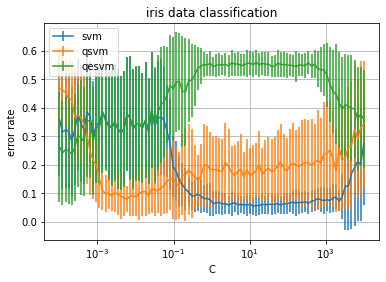

In [5]:
import matplotlib.pyplot as plt
plt.errorbar(C[:], err_mean[:, 0], yerr=err_std[:, 0], label='svm')
plt.errorbar(C[:], err_mean[:, 1], yerr=err_std[:, 1], label='qsvm')
plt.errorbar(C[:], err_mean[:, 2], yerr=err_std[:, 2], label='qesvm')
plt.xscale('log')

plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('error rate')
plt.title('iris data classification')
plt.show()